In [1]:
%load_ext autoreload
%autoreload 2 

In [12]:
import sys, os

sys.path.append("..")
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

from src.preproecess import Preprocesser

## 0. Data preprocessing


In [26]:
src_path = Path("../data/error/WD/Material_ID/")
dst_path = Path("../data/error/WD/Segmentation/")
dst_path.mkdir(parents=True, exist_ok=True)

In [25]:
for root, dirs, files in os.walk(src_path):
    for _file in files:
        if _file == ".DS_Store":
            continue
        root_path = Path(root)
        dst_path = Path(root.replace("Material_ID", "Segmentation"))
        dst_path.mkdir(parents=True, exist_ok=True)
        img = np.array(Image.open(root_path / _file))
        seg = np.apply_along_axis(preprocesser.rgb2idxByNearest, -1, img)
        Image.fromarray(seg.astype(np.uint8)).save(f"{dst_path / _file.replace('.jpg', '.png')}")

## 1. Dataset


In [13]:
preprocesser = Preprocesser(
    paths=[
        "../data/raw/cStud/Material_ID/",
        "../data/raw/cmu/Material_ID/",
        "../data/raw/tile/Material_ID/",
        "../data/raw/WD/Material_ID/",
    ]
)

### Verify data


In [24]:
test_images = []
test_images.append(np.array(Image.open("../data/raw/cmu/Material_ID/01.0028.jpg")))
test_images.append(np.array(Image.open("../data/raw/cStud/Material_ID/01.0031.jpg")))
test_images.append(np.array(Image.open("../data/raw/tile/Material_ID/01.0329.jpg")))
test_images.append(np.array(Image.open("../data/raw/WD/Material_ID/01.0327.jpg")))

In [26]:
segmentations = [
    np.apply_along_axis(preprocesser.rgb2idxByNearest, -1, i[:, :, :]) for i in test_images
]

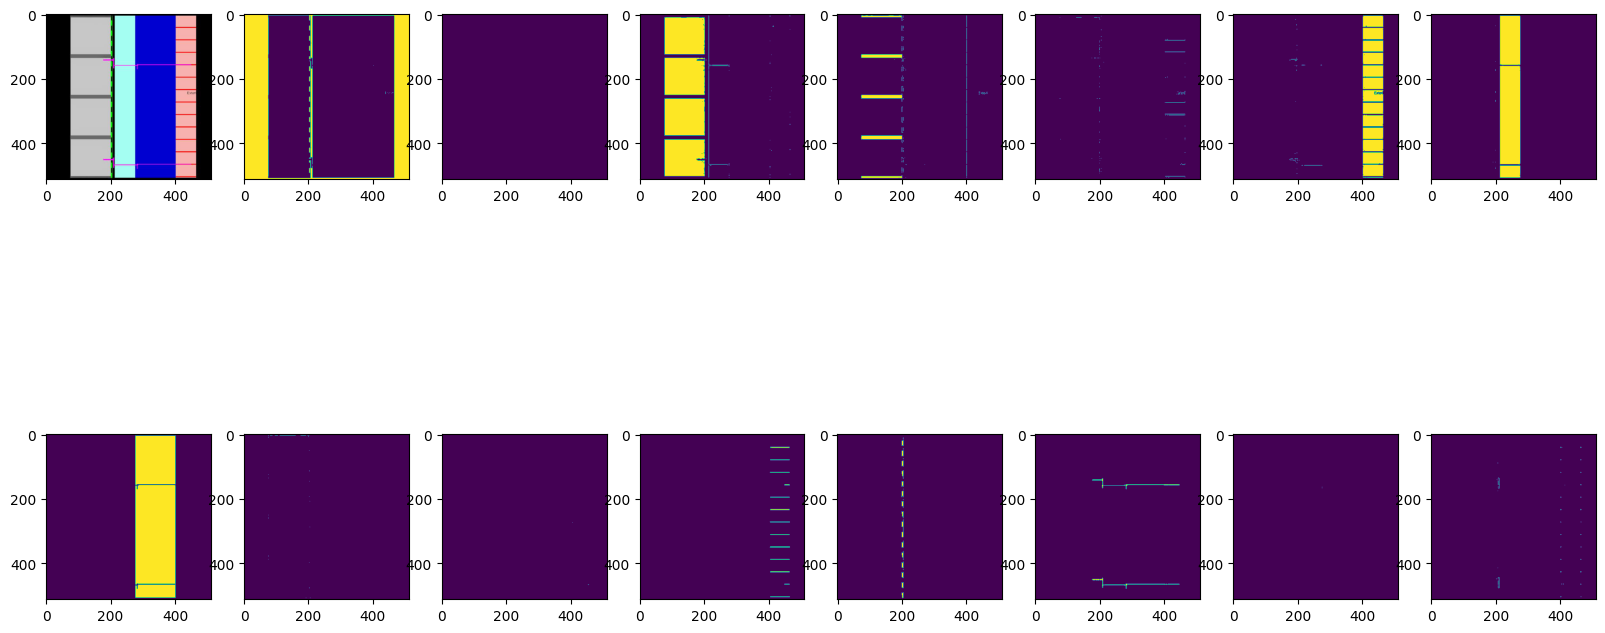

In [27]:
idx = 0

plt.figure(figsize=(20, 10))
plt.subplot(2, 8, 1)
plt.imshow(test_images[idx])
for j in range(15):
    plt.subplot(2, 8, j + 2)
    plt.imshow(segmentations[idx] == j)

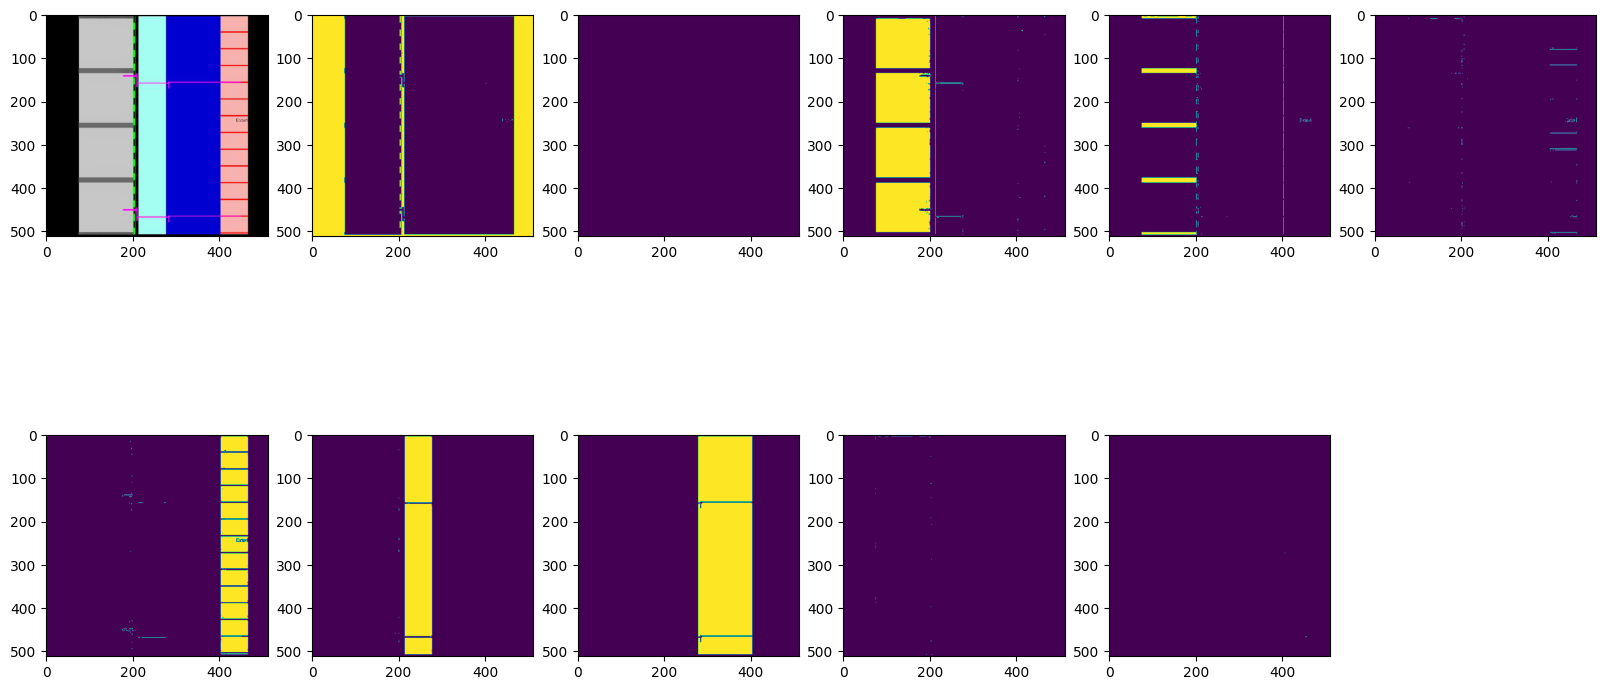

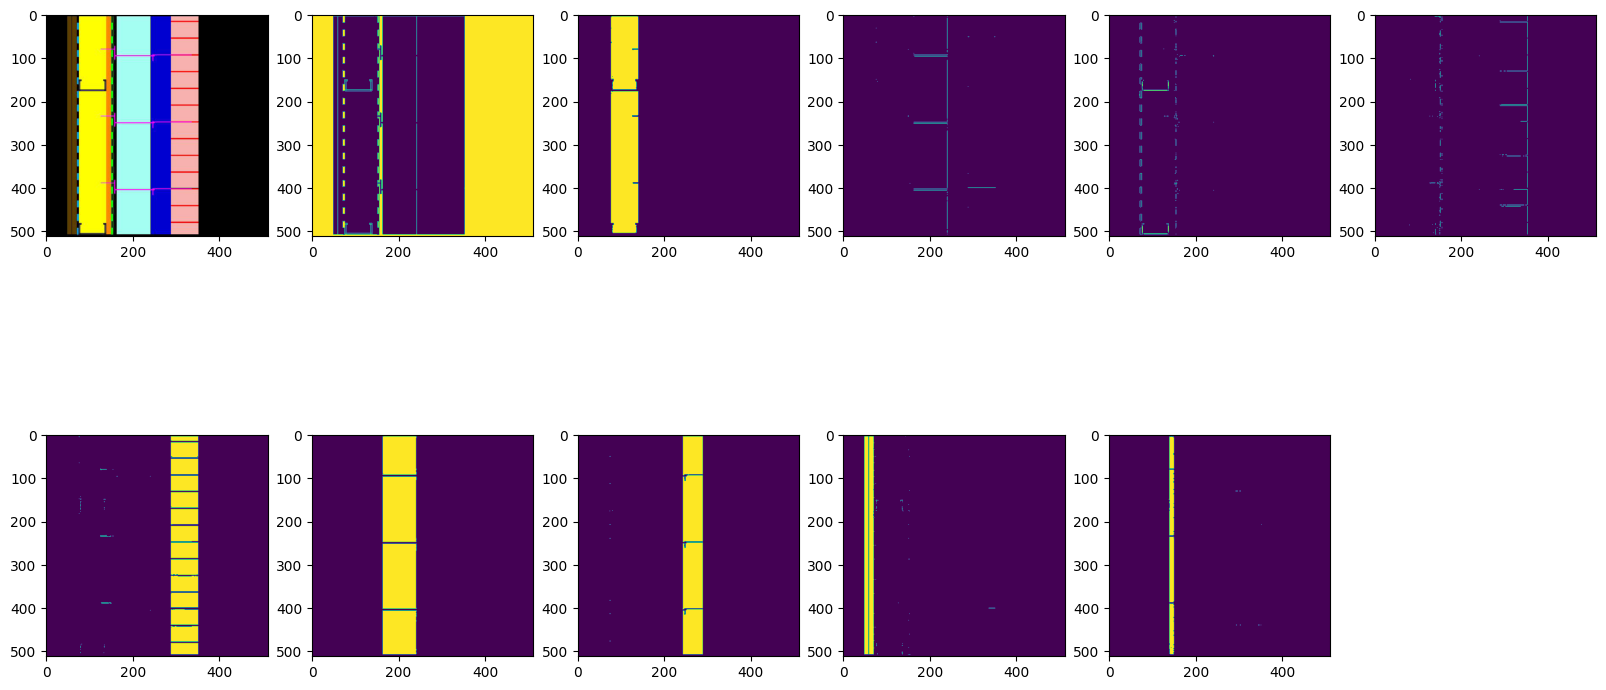

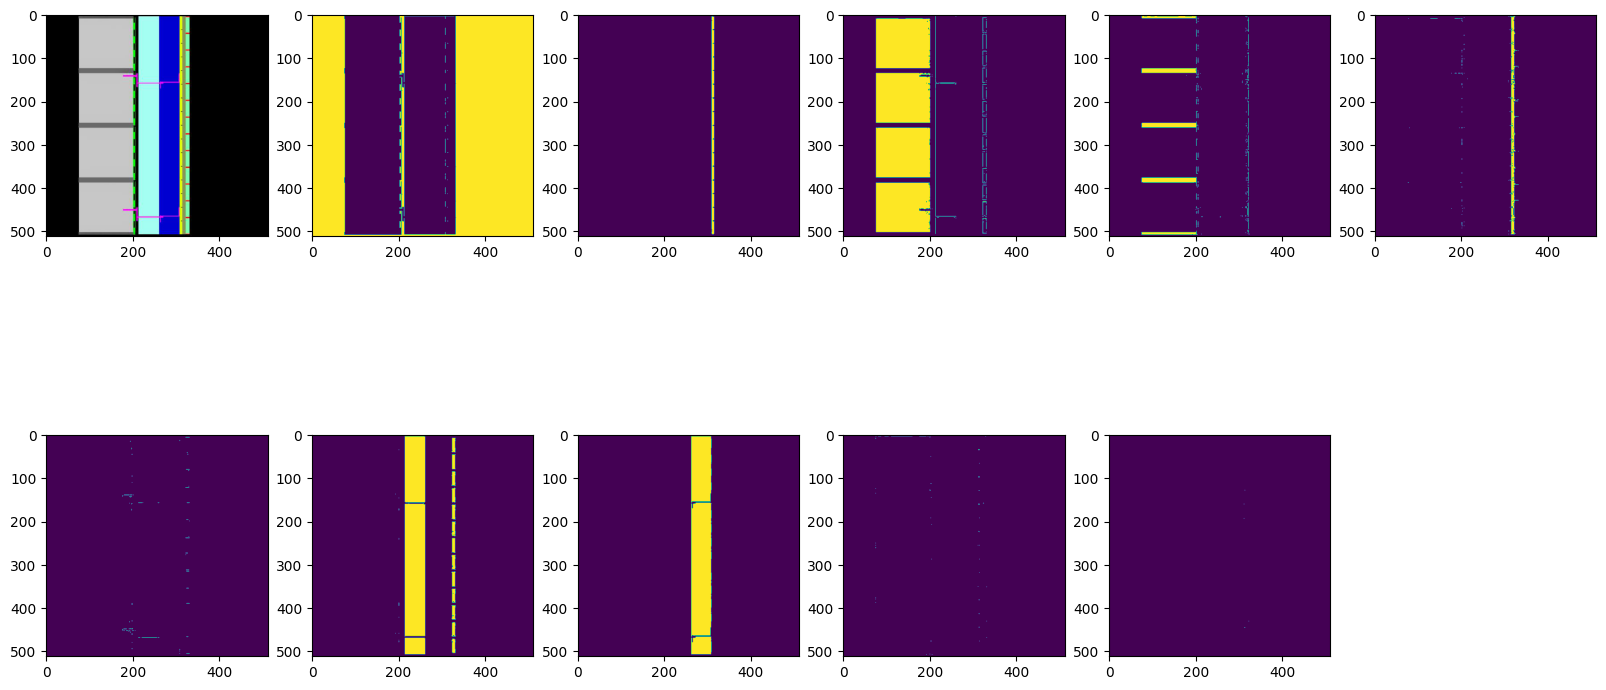

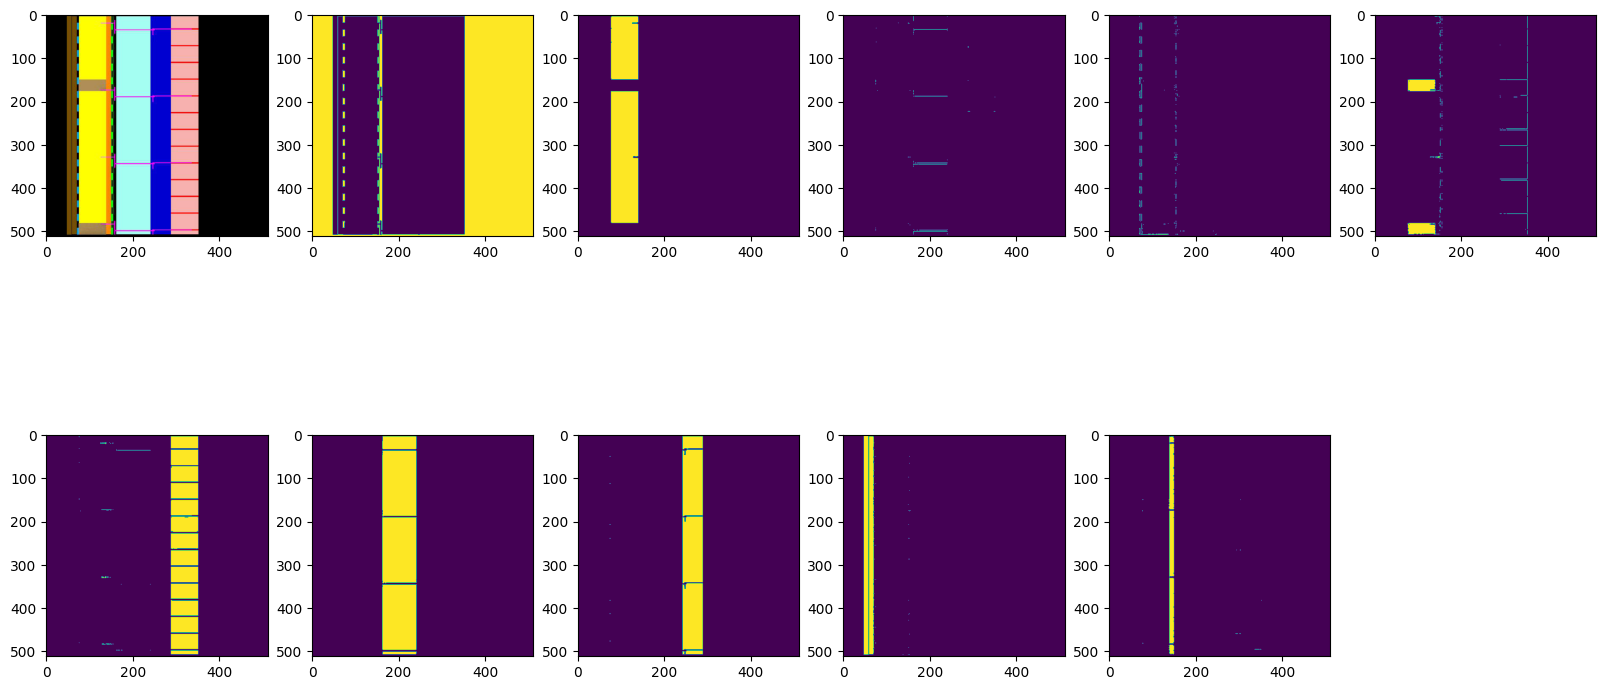

In [28]:
for i in range(len(test_images)):
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 6, 1)
    plt.imshow(test_images[i])
    for j in range(10):
        plt.subplot(2, 6, j + 2)
        plt.imshow(segmentations[i] == j)

## 2. Ready Dataset


In [4]:
import albumentations as A
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from src.dataset import WallSectionDataset, splitDataset
from src.preproecess import RGB2IDX

In [69]:
# Normalized는 꼭 할 필요는 없어 보이는데...
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

train_transform = A.Compose(
    [
        A.RandomCrop(width=512, height=512),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=ADE_MEAN, std=ADE_STD),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(width=512, height=512),
        A.Normalize(mean=ADE_MEAN, std=ADE_STD),
    ]
)

wall_dataset = WallSectionDataset(
    root_paths=["../data/raw/WD/", "../data/raw/cStud/", "../data/raw/cmu/", "../data/raw/tile/"],
    transform=train_transform,
)

In [70]:
train_dataset, test_dataset = splitDataset(wall_dataset)

In [18]:
len(test_dataset)

804

In [71]:
for i in train_dataset:
    if i[1].shape != (512, 512):
        print(i[1].shape)

### verify


In [72]:
(
    image,
    segmentation_map,
) = train_dataset[109 * 2 + 1]
print(image.shape)
print(segmentation_map.shape)

(3, 512, 512)
(512, 512)


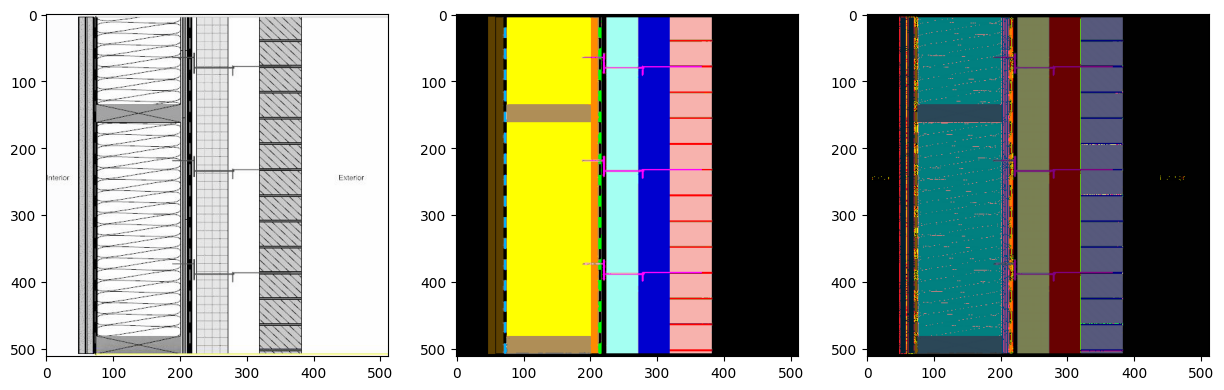

In [73]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
unnormalized_image = (image * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
plt.imshow(unnormalized_image)

plt.subplot(1, 3, 2)
color_segmentation_map = np.zeros(
    (segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8
)  # height, width, 3
for label, color in enumerate(RGB2IDX):
    color_segmentation_map[segmentation_map == label, :] = color
plt.imshow(color_segmentation_map)

plt.subplot(1, 3, 3)
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = np.moveaxis(image, 0, -1) * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.imshow(img)
plt.show()

## 3. DataLoaders


In [74]:
from transformers import Mask2FormerImageProcessor

from torch.utils.data import DataLoader
import torch

In [75]:
# Create a preprocessor
preprocessor = Mask2FormerImageProcessor(
    ignore_index=0, reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False
)

In [76]:
def collate_fn(batch):
    inputs = list(zip(*batch))
    images = inputs[0]
    segmentation_maps = inputs[1]
    # this function pads the inputs to the same size,
    # and creates a pixel mask
    # actually padding isn't required here since we are cropping
    batch = preprocessor(
        images,
        segmentation_maps=segmentation_maps,
        return_tensors="pt",
    )
    batch["original_images"] = inputs[1]
    batch["original_segmentation_maps"] = inputs[1]
    return batch


train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [59]:
train_dataloader.dataset._originl_image_path[idx]

PosixPath('../data/raw/WD/BW/01.0749.jpg')

In [77]:
for idx in range(len(train_dataloader.dataset)):
    images, seg_map = train_dataloader.dataset[idx]
    batch = preprocessor(images, segmentation_maps=seg_map, return_tensors="pt")

### verify


In [38]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape)
    else:
        print(k, v[0].shape)

pixel_values torch.Size([2, 3, 512, 512])
pixel_mask torch.Size([2, 512, 512])
mask_labels torch.Size([10, 512, 512])
class_labels torch.Size([10])
original_images (512, 512)
original_segmentation_maps (512, 512)


In [39]:
pixel_values = batch["pixel_values"][0].numpy()
pixel_values.shape

(3, 512, 512)

In [40]:
def visualize_mask(labels, label_name):
    print("Label:", label_name)
    idx = labels.index(label_name)

    visual_mask = (batch["mask_labels"][0][idx].bool().numpy() * 255).astype(np.uint8)
    return Image.fromarray(visual_mask)

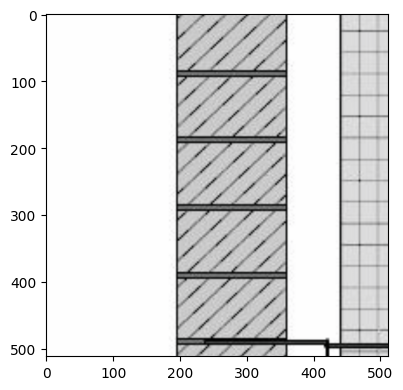

In [41]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
unnormalized_image = (pixel_values * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[
    :, None, None
]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
plt.imshow(unnormalized_image)
plt.show()

In [42]:
len(batch["mask_labels"][0])

10

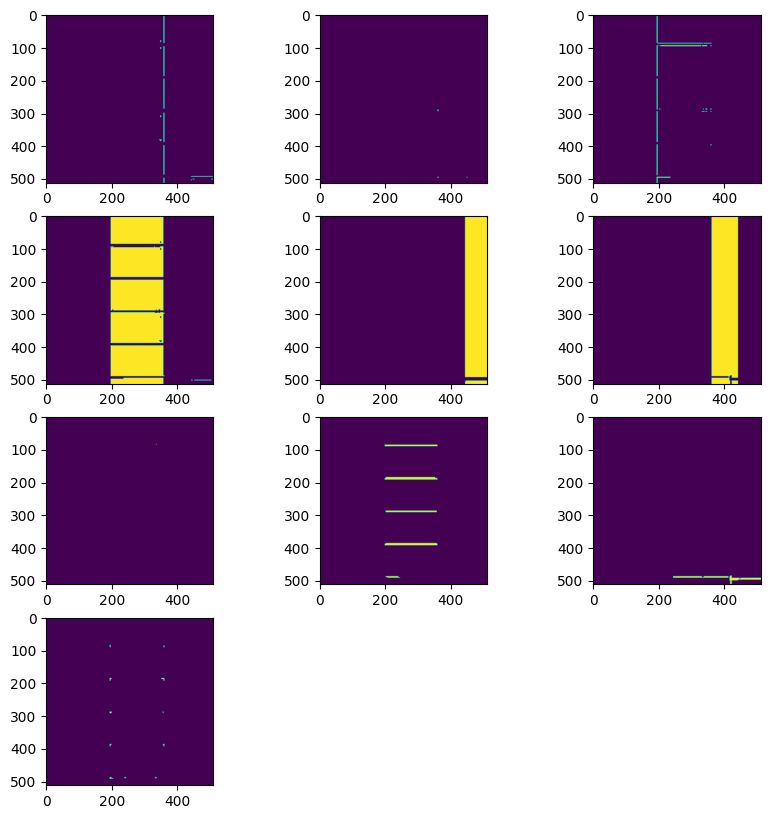

In [43]:
plt.figure(figsize=(10, 10))
for i in range(len(batch["mask_labels"][0])):
    plt.subplot(4, 3, i + 1)
    plt.imshow(batch["mask_labels"][0][i])

## 4. Define Model


In [85]:
for i in RGB2IDX

[[0, 0, 0],
 [255, 255, 0],
 [199, 199, 199],
 [106, 106, 106],
 [175, 142, 87],
 [247, 178, 173],
 [164, 255, 242],
 [0, 0, 207],
 [93, 64, 0],
 [255, 138, 0],
 [255, 0, 0],
 [0, 255, 0],
 [255, 0, 255],
 [0, 178, 255],
 [141, 0, 46]]

In [44]:
from transformers import Mask2FormerForUniversalSegmentation

model = Mask2FormerForUniversalSegmentation.from_pretrained(
    "facebook/mask2former-swin-small-ade-semantic",
    id2label={idx: "{idx}" for idx in range(len(RGB2IDX))},
    ignore_mismatched_sizes=True,
)

Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-small-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([16, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([16]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([16]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Compute initial loss


In [46]:
outputs = model(
    batch["pixel_values"], class_labels=batch["class_labels"], mask_labels=batch["mask_labels"]
)

In [47]:
outputs.loss

tensor([100.5096], grad_fn=<AddBackward0>)

### Train the model


In [48]:
!pip install -q evaluate

In [91]:
import evaluate

metric = evaluate.load("mean_iou")

AttributeError: partially initialized module 'charset_normalizer' has no attribute 'md__mypyc' (most likely due to a circular import)

In [ ]:
import torch
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

running_loss = 0.0
num_samples = 0
for epoch in range(100):
    print("Epoch:", epoch)
    model.train()
    for idx, batch in enumerate(tqdm(train_dataloader)):
        # Reset the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(
            pixel_values=batch["pixel_values"].to(device),
            mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
            class_labels=[labels.to(device) for labels in batch["class_labels"]],
        )

        # Backward propagation
        loss = outputs.loss
        loss.backward()

        batch_size = batch["pixel_values"].size(0)
        running_loss += loss.item()
        num_samples += batch_size

        if idx % 100 == 0:
            print("Loss:", running_loss / num_samples)

        # Optimization
        optimizer.step()

    model.eval()
    for idx, batch in enumerate(tqdm(test_dataloader)):
        if idx > 5:
            break

        pixel_values = batch["pixel_values"]

        # Forward pass
        with torch.no_grad():
            outputs = model(pixel_values=pixel_values.to(device))

        # get original images
        original_images = batch["original_images"]
        target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
        # predict segmentation maps
        predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(
            outputs, target_sizes=target_sizes
        )

        # get ground truth segmentation maps
        ground_truth_segmentation_maps = batch["original_segmentation_maps"]

        metric.add_batch(
            references=ground_truth_segmentation_maps, predictions=predicted_segmentation_maps
        )

    # NOTE this metric outputs a dict that also includes the mIoU per category as keys
    # so if you're interested, feel free to print them as well
    print("Mean IoU:", metric.compute(num_labels=len(id2label), ignore_index=0)["mean_iou"])